# Linear Regression

In [1]:
!pip install d2l==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.1 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.2
    Uninstalling pyparsing-3.1.2:
      Successfully uninstalled pyparsing-3.1.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: matplotlib-in

In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

## Defining the Model

- Initialize weights by drawing random numbers from a normal distribution with mean 0 and a standard deviation of 0.01
- set bias 0

In [3]:
class LinearRegressionScratch(d2l.Module): # 모델 생성 / 파라미터 준비
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__() # d2l.Module 상속
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True) # w,b : SGD를 통한 update 필요

- weight **w**, input features **X**, bias **b**(scalar)

In [4]:
@d2l.add_to_class(LinearRegressionScratch)
def forward(self, X):
    return torch.matmul(X, self.w) + self.b # input * weight + bias

## Defining the Loss Function

- transform true value y into the predicted value's shape y_hat
- averaged loss value를 최종결과로 return

In [5]:
@d2l.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean() # loss function : MSE

## Defining the Optimization Algorithm

과제는 아니지만, 전체적인 deep learning pipeline을 파악해주세요!

In [6]:
class SGD(d2l.HyperParameters):
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self): # update
        for param in self.params:
            param -= self.lr * param.grad # 파라미터의 gradient 업데이트

    def zero_grad(self):
        for param in self.params: # initialize
            if param.grad is not None: # 파라미터의 gradient 초기화
                param.grad.zero_()

In [7]:
@d2l.add_to_class(LinearRegressionScratch)
def configure_optimizers(self): # optimizer
    return SGD([self.w, self.b], self.lr)

##Training

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$


In [8]:
@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)
def fit_epoch(self):
    self.model.train() # train 모드 활성화
    for batch in self.train_dataloader:
      ### train_dataloader : train 배치를 생성하는 생성기
      ### return self.get_dataloader(train=True)
        loss = self.model.training_step(self.prepare_batch(batch))
        ### training_step : 손실 계산
        ### l = self.loss(self(*batch[:-1]), batch[-1])
        self.optim.zero_grad() # backward 전에 gradient 초기화
        with torch.no_grad(): # gradient 계산 없이
            loss.backward() # 역전파
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step() # update
        self.train_batch_idx += 1 # 다음 배치
    if self.val_dataloader is None:
        return
    self.model.eval() # 평가 모드 전환 (드롭아웃 비활성화, 변수 update 중지)
    for batch in self.val_dataloader: # return self.get_dataloader(train=False)
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
            ### validation_step : 평가 측정값 보고
            ### l = self.loss(self(*batch[:-1]), batch[-1])
        self.val_batch_idx += 1

loss를 확인해봅시다 !

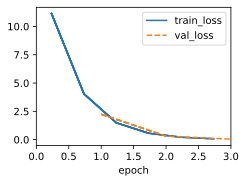

In [9]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

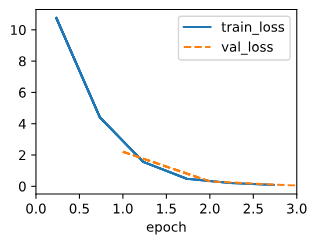

-정답 그림

# Softmax Regression

다양한 X를 설정해서 진행해주셔도 좋을 거 같습니다 :>

In [10]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdims=True), X.sum(1, keepdims=True) # keepdims : sum 이후에도 차원 유지

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

(**
$$\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.$$
**)

softmax를 구현해주세요

In [11]:
def softmax(X):
    X_exp = torch.exp(X) #지수화
    sum = X_exp.sum(1, keepdims=True) #정규화 상수
    return X_exp/sum

In [12]:
X = torch.rand((2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1527, 0.2488, 0.1532, 0.2956, 0.1498],
         [0.2623, 0.1459, 0.1950, 0.2643, 0.1325]]),
 tensor([1.0000, 1.0000]))

## Model

- 28*28 pixel image를 가지고, flatten하여 vector로 만듦
- 10 class 존재

In [13]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

In [14]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
    X = X.reshape((-1, self.W.shape[0])) # W의 dimension(num_inputs)대로 X reshape
    return softmax(torch.matmul(X, self.W) + self.b)

## Cross-Entropy Loss

다양한 y로 연습해보셔도 좋을 거 같습니다 :>

In [15]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

Cross entropy loss를 구현해주세요

In [16]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()
    # 각 sample에 대한 실제 클래스의 예측 확률의 음의 로그 평균
cross_entropy(y_hat, y)

tensor(1.4979)

In [17]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

## Training

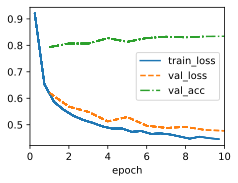

In [18]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
# 이미지의 크기 28x28 = 784 / 클래스의 수 10
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

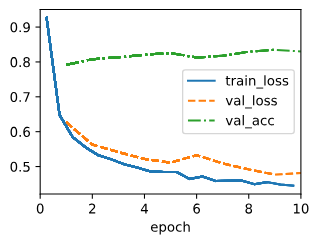

-정답 그림

## Prediction

어떤 방식으로 prediction 및 사진이 나오는지 확인해주세요

In [19]:
X, y = next(iter(data.val_dataloader())) # 검증 데이터 로더에서 첫 배치의 데이터를 가져옴
preds = model(X).argmax(axis=1) # 예측 수행 / 가장 높은 확률의 인덱스 반환
preds.shape

torch.Size([256])

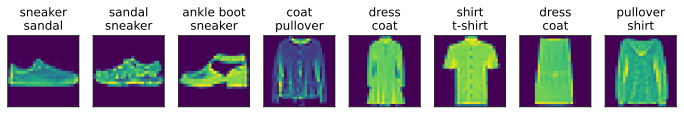

In [20]:
wrong = preds.type(y.dtype) != y # y와 데이터 타입 맞춤 / 잘못 예측된 항목의 인덱스 찾기
X, y, preds = X[wrong], y[wrong], preds[wrong] # wrong 데이터 불러오기
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))] # 실제-예측 순으로 레이블 문자열 프린트
data.visualize([X, y], labels=labels) # 시각화

# Review

## Numpy version

### data generation

In [21]:
import numpy as np

true_b = 1
true_w = 2

N = 100

np.random.seed(42)
x = np.random.rand(N,1)  # Uniform
epsilon = (0.1 * np.random.randn(N,1))  # standard normal dist  # noise
y = true_w * x + true_b +  epsilon

### train-validation split

In [22]:
# Shuffles the indices
idx = np.arange(N)
split_index = int(N * 0.8)

train_idx = idx[ : split_index]
val_idx = idx[split_index : ]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

### gradient descent for linear regression

In [23]:
# 실행시간을 측정해주는 Decorator 입니다.

import time
def timer(func):
  def wrapper(*args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    computation_time = end_time - start_time
    print(f"Execution time of {func.__name__}: {computation_time} seconds")
    return result
  return wrapper

In [24]:
@timer
def train_model_numpy(lr = 0.1, epochs = 1000):
  # Initialize parameters
  b = np.random.randn(1)
  w = np.random.randn(1)

  for epoch in range(epochs):
    # Loss computation
    y_hat = b + w * x_train
    error = (y_hat - y_train)
    mse_loss = np.mean(error**2)

    # Gradient computation
    b_grad = 2 * np.mean(error)
    w_grad = 2 * np.mean(error * x_train)
    b = b - lr * b_grad
    w = w - lr * w_grad
  return b, w


In [25]:
b, w = train_model_numpy()
print("b_estimate:{}, w_estimate:{}".format(b,w))

Execution time of train_model_numpy: 0.03640031814575195 seconds
b_estimate:[1.02341376], w_estimate:[1.93680725]


## Pytorch version

### data generation

In [26]:
import torch

# create tensor at CPU:
x_train_tensor = torch.as_tensor(x_train)
y_train_tensor = torch.as_tensor(y_train)

# create tensor at GPU:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
x_train_tensor = torch.as_tensor(x_train).to(device)
y_train_tensor = torch.as_tensor(y_train).to(device)


### gradient descent

In [27]:
@timer
def train_model_torch(lr = 0.1, epochs=1000):
  # Initialize parameters
  b = torch.randn(1, requires_grad = True, dtype = torch.float, device = device)
  w = torch.randn(1, requires_grad = True, dtype = torch.float, device = device)

  for epoch in range(epochs):
    # Loss computation
    y_hat = b + w * x_train_tensor
    error = (y_hat - y_train_tensor)
    mse_loss = torch.mean(error ** 2)
    # Gradient computation and descent
    mse_loss.backward()
    with torch.no_grad():
      b -= lr * b.grad  # in-place operation
      w -= lr * w.grad
    b.grad.zero_()
    w.grad.zero_()
  return b, w

In [28]:
b, w = train_model_torch()
print("b_estimate:{}, w_estimate:{}".format(b,w))

Execution time of train_model_torch: 0.22408223152160645 seconds
b_estimate:tensor([1.0234], requires_grad=True), w_estimate:tensor([1.9368], requires_grad=True)


### additional -> optimizer를 사용하기 (gradient descent)

In [29]:
import torch.optim as optim
import torch.nn as nn

@timer
def train_model_torch(lr = 0.1, epochs=1000):
  # Initialize parameters
  b = torch.randn(1, requires_grad = True, dtype = torch.float, device = device)
  w = torch.randn(1, requires_grad = True, dtype = torch.float, device = device)
  parameters = [b, w]
  optimizer = optim.SGD(parameters, lr = lr)
  mse_loss = nn.MSELoss()

  for epoch in range(epochs):
    # Loss computation
    y_hat = b + w * x_train_tensor
    loss = mse_loss(y_hat, y_train_tensor)
    # Gradient computation and descent
    loss.backward()
    optimizer.step() # 경사하강법 연산, step 한 번을 밟는다!
    optimizer.zero_grad()
  return b, w

In [30]:
b, w = train_model_torch()
print("b_estimate:{}, w_estimate:{}".format(b,w))

Execution time of train_model_torch: 0.562150239944458 seconds
b_estimate:tensor([1.0234], requires_grad=True), w_estimate:tensor([1.9368], requires_grad=True)
